# Observing problems with NN training
* Suspicion: due to the tail of relatively large elevation errors worst 1% > 8.9 meters (trees) the NN is getting punished mostly for these (unfixable?) errors instead of focusing on the smaller errors it's supposed to learn to correct

## Find the min & max of the whole dataset

In [2]:
import rioxarray
import glob
import torch
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
import shapely
import pathlib
import geopandas as gpd

In [3]:
mosaics = list(glob.glob("mosaic*.tif"))
mosaics

['mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-DEM.tif',
 'mosaic_TRAIN_1020010043455300.r100_ortho_1.0m_ba.tif',
 'mosaic_TRAIN_1020010042D39D00.r100_ortho_1.0m_ba.tif',
 'mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-IntersectionErr.tif',
 'mosaic_TRAIN_USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif']

In [6]:
for m in mosaics:
    x = rioxarray.open_rasterio(m, masked=True)
    print(f"{m}: min={float(x.min()):.2f}, max={float(x.max()):.2f}")
    print(f"\tmean={float(x.mean()):.2f}, std={float(x.std()):.2f}")

mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-DEM.tif: min=0.00, max=3266.77
	mean=1470.81, std=750.69
mosaic_TRAIN_1020010043455300.r100_ortho_1.0m_ba.tif: min=0.00, max=2007.00
	mean=307.36, std=388.75
mosaic_TRAIN_1020010042D39D00.r100_ortho_1.0m_ba.tif: min=0.00, max=2045.00
	mean=357.07, std=395.84
mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-IntersectionErr.tif: min=0.00, max=6.98
	mean=0.37, std=0.57
mosaic_TRAIN_USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif: min=0.00, max=3266.78
	mean=1512.84, std=718.11


In [54]:
x = torch.rand([20,5,256,256])
normalized_inputs = torch.zeros_like(x)

min_max_per_band = [
    [0,3266.77],
    [0,2045],
    [0,2007],
    [0,6.98],
    [0,1]
]
min_max_per_band = np.array(min_max_per_band)
for band in range(len(min_max_per_band)):
    normalized_inputs[:,band] = (x[:,band] - min_max_per_band[band,0]) / min_max_per_band[band,1]

In [53]:
normalized_inputs.max()

tensor(1.0000)

# find which tiles do NOT have trees in them to make a smaller training+val set

In [7]:
val_dir = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/VALIDATION_tile_stack_baker_128_global_coreg/"
train_dir = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/TRAIN_tile_stack_baker_128_global_coreg/"

In [59]:
val_path = pathlib.Path(val_dir)
train_path = pathlib.Path(train_dir)

In [ ]:
keep_train = []
keep_val = []


In [64]:

keep = keep_train
p = train_path
for stack_dir in list(p.glob("*/lower_easton3/files_to_zip")):#[:15]:
    initial_dem_fn = stack_dir / "WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-DEM_holes_filled.tif"
    lidar_dem_fn = list(stack_dir.glob("USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif"))[0]
    initial_dem = rioxarray.open_rasterio(initial_dem_fn, masked=True)
    lidar_dem = rioxarray.open_rasterio(lidar_dem_fn, masked=True)
    diff = initial_dem - lidar_dem
    # print(diff.min(), diff.max(), diff.mean(), diff.median())
    diff_1d = diff.data.reshape(-1)
    # plt.figure()
    # plt.hist(diff_1d, bins=100)
    pct5 = np.percentile(diff_1d, 5)
    pct95 = np.percentile(diff_1d, 95)
    # print(pct5, pct95)
    tile_id = os.path.basename(lidar_dem_fn).split("_")[5]
    # print(tile_id)
    if pct95-pct5 > 10:
        print(f"Discarding {tile_id}")
    else:
        keep.append(tile_id)
    

Discarding 10UEV8909
Discarding 10UEV8603
Discarding 10UEU8697
Discarding 10UEV8307
Discarding 10UEU8796
Discarding 10UEV8710
Discarding 10UEU9095
Discarding 10UEV8609
Discarding 10UEU8497
Discarding 10UEV8407
Discarding 10UEU8895
Discarding 10UEV8908
Discarding 10UEV8300
Discarding 10UEU8896
Discarding 10UEU8696
Discarding 10UEU9096
Discarding 10UEV8305
Discarding 10UEU8898
Discarding 10UEU8897
Discarding 10UEV8302
Discarding 10UEU9098
Discarding 10UEV8306
Discarding 10UEV9009
Discarding 10UEV8403
Discarding 10UEU8395
Discarding 10UEV8402
Discarding 10UEV8309
Discarding 10UEV8910
Discarding 10UEU8995
Discarding 10UEU8996
Discarding 10UEU8595
Discarding 10UEU8997
Discarding 10UEU9099
Discarding 10UEV8809
Discarding 10UEU8396
Discarding 10UEU8397
Discarding 10UEV8709
Discarding 10UEV8509
Discarding 10UEU9097
Discarding 10UEU8596
Discarding 10UEV8808
Discarding 10UEU8797
Discarding 10UEU8398
Discarding 10UEV8400
Discarding 10UEV8301
Discarding 10UEV9000
Discarding 10UEV8610
Discarding 10

In [62]:
keep_val

['10UEV8807',
 '10UEV8501',
 '10UEV8707',
 '10UEU8599',
 '10UEV8601',
 '10UEV8903',
 '10UEV8801',
 '10UEV8304',
 '10UEV9006']

In [65]:
keep_train

['10UEU8699',
 '10UEV8803',
 '10UEV8507',
 '10UEV9003',
 '10UEU8798',
 '10UEU8499',
 '10UEV8606',
 '10UEV8806',
 '10UEV9001',
 '10UEV8703',
 '10UEV9007',
 '10UEU8698',
 '10UEV8902',
 '10UEU8597',
 '10UEV8701',
 '10UEV8500',
 '10UEV8608',
 '10UEV8600',
 '10UEV8405',
 '10UEU8799',
 '10UEV8906',
 '10UEV8802',
 '10UEU8598',
 '10UEV8404',
 '10UEV8900',
 '10UEV8303',
 '10UEV8408',
 '10UEU8498',
 '10UEV8901',
 '10UEV9004',
 '10UEV8503',
 '10UEV8805',
 '10UEU8899',
 '10UEV8605',
 '10UEV8700',
 '10UEV8607',
 '10UEV8406',
 '10UEV8904',
 '10UEV8800',
 '10UEV8310',
 '10UEV8401',
 '10UEV8602',
 '10UEV8907',
 '10UEV8504',
 '10UEV9002',
 '10UEV8702',
 '10UEV8604',
 '10UEV8706',
 '10UEV8708',
 '10UEV8508',
 '10UEV8506',
 '10UEV8705',
 '10UEV8409',
 '10UEV8502',
 '10UEV8905',
 '10UEV8704',
 '10UEV8804',
 '10UEV9008',
 '10UEV9005',
 '10UEV8505']

In [1]:
project_root = pathlib.Path("/mnt/1.0_TB_VOLUME/sethv")
usgs_dir = os.path.join(project_root, "resdepth_all/deep-elevation-refinement/notebooks/dataset_search/")
biggest_bbox = shapely.geometry.box(583000, 5411000, 591000, 5395000)

gdf = gpd.read_file(os.path.join(usgs_dir, "Mt_Baker_LiDAR_Tile_Index.shp"))
fig, ax = plt.subplots(figsize=(6,6))
gdf.plot(ax=ax, alpha=0.2)
gdf[gdf["Tile"].isin(keep_train)].plot(ax=ax, color="red")
gdf[gdf["Tile"].isin(keep_val)].plot(ax=ax, color="blue")
plt.title(f"keep {len(keep_train)} train and {len(keep_val)} val tiles with small errors")

NameError: name 'pathlib' is not defined

In [91]:

val_dataset_small_errors_only = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/VAL_tile_stack_baker_small_errors_only"
train_dataset_small_errors_only = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/TRAIN_tile_stack_baker_small_errors_only"
!mkdir -p $train_dataset_small_errors_only
!mkdir -p $val_dataset_small_errors_only

In [67]:
keep_val

['10UEV8807',
 '10UEV8501',
 '10UEV8707',
 '10UEU8599',
 '10UEV8601',
 '10UEV8903',
 '10UEV8801',
 '10UEV8304',
 '10UEV9006']

In [96]:
for stack_dir in list(train_path.glob("*/lower_easton3/files_to_zip")):#[:15]:
    initial_dem_fn = stack_dir / "WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-DEM_holes_filled.tif"
    lidar_dem_fn = list(stack_dir.glob("USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif"))[0]
    tile_id = os.path.basename(lidar_dem_fn).split("_")[5]
    if tile_id not in keep_train:
        continue

    initial_dem = rioxarray.open_rasterio(initial_dem_fn, masked=True)
    lidar_dem = rioxarray.open_rasterio(lidar_dem_fn, masked=True)
    diff = abs(initial_dem - lidar_dem)
    print(tile_id)
    print(f"min={diff.min():.2f}, max={diff.max():.2f}, mean={diff.mean():.2f}, median={diff.median():.2f}")
    diff_1d = diff.data.reshape(-1)
    # plt.figure()
    # plt.hist(diff_1d, bins=100)
    pct5 = np.percentile(diff_1d, 5)
    pct95 = np.percentile(diff_1d, 95)
    print(f"5th & 95th percentile {pct5:.2f} and {pct95:.2f}")

10UEU8699
min=0.00, max=43.10, mean=0.80, median=0.48
5th & 95th percentile 0.05 and 2.71
10UEV8803
min=0.00, max=919.03, mean=1.34, median=0.59
5th & 95th percentile 0.06 and 5.48
10UEV8507
min=0.00, max=129.98, mean=0.85, median=0.40
5th & 95th percentile 0.03 and 3.40
10UEV9003
min=0.00, max=1221.84, mean=2.37, median=0.74
5th & 95th percentile 0.06 and 7.26
10UEU8798
min=0.00, max=38.51, mean=1.08, median=0.34
5th & 95th percentile 0.03 and 4.42
10UEU8499
min=0.00, max=30.83, mean=1.06, median=0.34
5th & 95th percentile 0.03 and 4.91
10UEV8606
min=0.00, max=196.48, mean=0.71, median=0.44
5th & 95th percentile 0.06 and 2.25
10UEV8806
min=0.00, max=185.44, mean=1.00, median=0.44
5th & 95th percentile 0.04 and 4.03
10UEV9001
min=0.00, max=47.55, mean=0.72, median=0.35
5th & 95th percentile 0.03 and 2.16
10UEV8703
min=0.00, max=39.36, mean=1.39, median=0.51
5th & 95th percentile 0.04 and 6.48
10UEV9007
min=0.00, max=55.40, mean=0.51, median=0.20
5th & 95th percentile 0.02 and 1.93
10UE

In [94]:
for stack_dir in list(train_path.glob("*/lower_easton3/files_to_zip")):
    tile_id = stack_dir.parts[-3].split("_")[-3] # gross
    # print(tile_id)
    if tile_id not in keep_train:
        continue
    # print(stack_dir.parent.parent)
    tile_dir = stack_dir.parent.parent
    !cp -r $tile_dir $train_dataset_small_errors_only
    # print(tile_id)

In [95]:
for stack_dir in list(val_path.glob("*/lower_easton3/files_to_zip")):
    tile_id = stack_dir.parts[-3].split("_")[-3] # gross
    if tile_id not in keep_val:
        continue
    tile_dir = stack_dir.parent.parent
    !cp -r $tile_dir $val_dataset_small_errors_only

# Compute stats for reduced training set

In [6]:
ddir = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/TRAIN_tile_stack_baker_small_errors_only/"

pattern_left="files_to_zip/1020010042D39D00.r100_ortho_1.0m_ba.tif"
mosaic_ortho_left = "small_errors_only_mosaic_TRAIN_1020010042D39D00.r100_ortho_1.0m_ba.tif"
!gdal_merge.py -o $mosaic_ortho_left `find $ddir -path "*$pattern_left"`

pattern_right="files_to_zip/1020010043455300.r100_ortho_1.0m_ba.tif"
mosaic_ortho_right = "small_errors_only_mosaic_TRAIN_1020010043455300.r100_ortho_1.0m_ba.tif"
!gdal_merge.py -o $mosaic_ortho_right `find $ddir -path "*$pattern_right"`

pattern_trierror="files_to_zip/WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-IntersectionErr.tif"
mosaic_trierror = "small_errors_only_mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-IntersectionErr.tif"
!gdal_merge.py -o $mosaic_trierror `find $ddir -path "*$pattern_trierror"`

pattern_initial_dem="WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-DEM_holes_filled.tif"
mosaic_initial_dem = f"small_errors_only_mosaic_TRAIN_{pattern_initial_dem}"
!gdal_merge.py -o $mosaic_initial_dem `find $ddir -path "*files_to_zip/$pattern_initial_dem"`

pattern_target="USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif"
mosaic_target = f"small_errors_only_mosaic_TRAIN_{pattern_target}"
!gdal_merge.py -o $mosaic_target `find $ddir -path "*files_to_zip/$pattern_target"`

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
for fn in [mosaic_ortho_left, mosaic_ortho_right, mosaic_trierror, mosaic_initial_dem, mosaic_target]:
    m = rioxarray.open_rasterio(fn, masked=True)
    print(f"{fn}: mean={m.mean():.2f}, std={m.std():.2f}")

small_errors_only_mosaic_TRAIN_1020010042D39D00.r100_ortho_1.0m_ba.tif: mean=293.65, std=425.82
small_errors_only_mosaic_TRAIN_1020010043455300.r100_ortho_1.0m_ba.tif: mean=262.90, std=409.16
small_errors_only_mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-IntersectionErr.tif: mean=0.12, std=0.15
small_errors_only_mosaic_TRAIN_WV01_20150911_1020010042D39D00_1020010043455300_aligned_crop_1.0m-DEM_holes_filled.tif: mean=1052.86, std=1017.68
small_errors_only_mosaic_TRAIN_USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif: mean=1052.88, std=1017.68


In [8]:
diff = rioxarray.open_rasterio(mosaic_initial_dem, masked=True) - rioxarray.open_rasterio(mosaic_target, masked=True)


In [11]:
ae = abs(diff)
ae.min(), ae.max(), ae.mean(), ae.median(), (ae**2).mean()

(<xarray.DataArray ()>
 array(0., dtype=float32)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(1221.8447, dtype=float32)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(0.6621257, dtype=float32)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(0.05957031, dtype=float32)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(19.610832, dtype=float32)
 Coordinates:
     spatial_ref  int64 0)

In [123]:
for p in [1,5,10,25,50,75,90,95,99,99.9, 99.99]:
    print(f"Value at {p}th percentile {np.percentile(ae,p)}")

Value at 1th percentile 0.0
Value at 5th percentile 0.0
Value at 10th percentile 0.0
Value at 25th percentile 0.0
Value at 50th percentile 0.0595703125
Value at 75th percentile 0.5478515625
Value at 90th percentile 1.302734375
Value at 95th percentile 2.6005859375
Value at 99th percentile 8.9248046875
Value at 99.9th percentile 24.3125
Value at 99.99th percentile 171.1562507811468


(array([5.5353389e+07, 3.2999050e+06, 3.2476030e+06, 3.1693920e+06,
        3.0737870e+06, 3.0190880e+06, 2.8437660e+06, 2.7170650e+06,
        2.5692100e+06, 2.4091140e+06, 2.2714570e+06, 2.0478310e+06,
        1.8760840e+06, 1.7062960e+06, 1.5465060e+06, 1.4210330e+06,
        1.2445360e+06, 1.1116650e+06, 9.9023800e+05, 8.8184700e+05,
        7.9975200e+05, 6.9987100e+05, 6.2616600e+05, 5.6544600e+05,
        5.1263400e+05, 4.7449400e+05, 4.2651200e+05, 3.9015500e+05,
        3.5807600e+05, 3.3212800e+05, 3.1369600e+05, 2.8489100e+05,
        2.6671900e+05, 2.4777500e+05, 2.3246200e+05, 2.2287400e+05,
        2.0681800e+05, 1.9528800e+05, 1.8481600e+05, 1.7546200e+05,
        1.6958500e+05, 1.5851800e+05, 1.5179000e+05, 1.4453300e+05,
        1.3829900e+05, 1.3550700e+05, 1.2778900e+05, 1.2342400e+05,
        1.1787400e+05, 1.1418800e+05, 1.1183300e+05, 1.0571400e+05,
        1.0268000e+05, 9.9331000e+04, 9.5618000e+04, 9.4797000e+04,
        8.9410000e+04, 8.7550000e+04, 8.4230000e

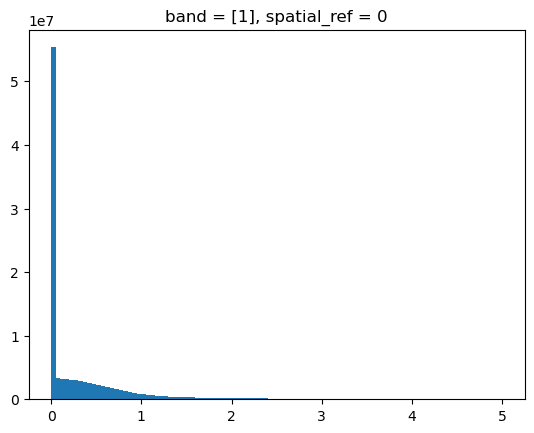

In [116]:
ae.plot.hist(bins=100, range=(0,5))